# COMPUTER VISION PROJECT - FRUIT INSPECTION
## FILIPPO COMASTRI
## AA 2022/2023

This project requires to develop a software system aimed at locating defects and imperfections in fruits. Each fruit is acquired through a NIR (Near Infra-Red) and a color camera with little parallax effect. Below there are the solutions proposed by me to three tasks.

## Preliminary steps

Those are the libraries required by the software system.

In [3]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import glob

Utility functions:
- **plot_images** : plots the images
- **get_img_filenames** : to generate the images filenames
- **get_samples_filenames**: to generate samples filenames

In [9]:
def plot_images(images,title="",color=False,rgb=True):
    for i in range(len(images)):
        plt.subplot(1,len(images),i+1).axis("off")
        if color and rgb : 
            plt.imshow(images[i])
        elif color and rgb==False:
            plt.imshow(cv.cvtColor(images[i],cv.COLOR_BGR2RGB))
        else:
            plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
    plt.title(title)        
    plt.show()

def get_img_filenames(task,start_dir='.'):
    nir_img_filenames = []
    rgb_img_filenames = []
    if task == 'first_task':
        for y in range(1,4):
            nir_img_filenames.append("{}/imgs/{}/C0_00000{}.png".format(start_dir,task,y))
            rgb_img_filenames.append("{}/imgs/{}/C1_00000{}.png".format(start_dir,task,y))
    elif task == 'second_task':
        for y in 4,5:
            nir_img_filenames.append("{}/imgs/{}/C0_00000{}.png".format(start_dir,task,y))
            rgb_img_filenames.append("{}/imgs/{}/C1_00000{}.png".format(start_dir,task,y))
    elif task == 'final_challenge':
        for y in range(6,11) :
            if(y>=10):
                nir_img_filenames.append("{}/imgs/{}/C0_0000{}.png".format(start_dir,task,y))
                rgb_img_filenames.append("{}/imgs/{}/C1_0000{}.png".format(start_dir,task,y))
            else:
                nir_img_filenames.append("{}/imgs/{}/C0_00000{}.png".format(start_dir,task,y))
                rgb_img_filenames.append("{}/imgs/{}/C1_00000{}.png".format(start_dir,task,y))

    return nir_img_filenames, rgb_img_filenames

def get_samples_filenames(start_dir='.'):
    samples = []
    for sample in glob.glob('{}/imgs/second_task/samples/sample_*.png'.format(start_dir)):
        samples.append(sample)
    return samples

# FIRST TASK

Images in folder “first task” show three apples with clear external defects. I have to outline the fruit by generating a binary mask and then search for the defects in each fruit.

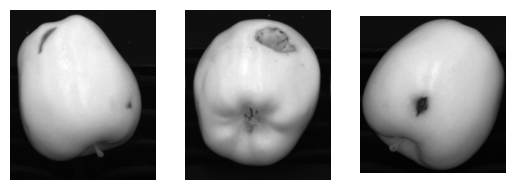

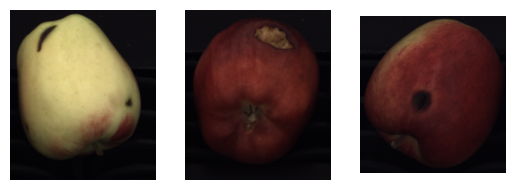

In [3]:
nir_img_filenames, rgb_img_filenames = get_img_filenames("first_task")
N = len(nir_img_filenames)

nir_img = []
rgb_img = []

for i in range(N):
    nir_img.append(cv.imread(nir_img_filenames[i],0))
    rgb_img.append(cv.imread(rgb_img_filenames[i]))

plot_images(nir_img)
plot_images(rgb_img,color=True,rgb=False)

I follow those steps:
1. I create a binary mask of the apples to outline them.
2. I detect defects using Canny's edge detector on the NIR image obtained by applying the binary mask previously computed.

## Create a **Binary Mask** to outline the fruits 

I have to outline the fruit by generating a binary mask

First, I used a global thresholding approach, using Otsu's method to calculate the threshold.

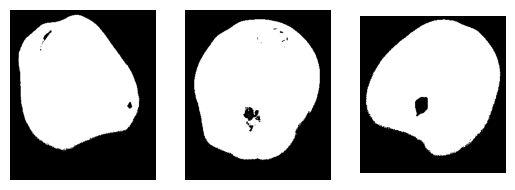

In [4]:
im_th = []

for i in range(N):
    _, im_thresh = cv.threshold(nir_img[i],None,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    im_th.append(im_thresh)
plot_images(im_th)    

As you can see in the image above, it works pretty well, but it isn't a super accurate segmentation because some parts of the apples are considered as background. For example, in the first and third images, the stalk of the apple and the region around are not considered foreground. This happens because the light isn't uniform in the images.

For this reason I decided to use **ADAPTIVE THRESHOLDING**,  which computes a binarization threshold at each image pixel, based on the intensities within a small neighbourhood. This type of thresholding can handle also images without uniform lighting across the scene. 

Adaptive thresholding is computationally more expensive compared to global thresholding. Using the binarization with Otsu's thresholding, even if not so precise, would require less time to compute the fruit's binary mask. In the assignment, there are no constraints on computational time. For this reason, I decided to maintain the solution with the adaptive threshold to outline more precisely apples. If there were time constraints we can use global thresholding with Otsu's method and,also if the segmentation of the fruits isn't super accurate, it allows the same to detect well the defects in the fruits.

Before thresholding, I apply a **bilateral filter** in order to denoise the image without blurring the edges (edge preserve smoothing). The values of *d* (Diameter of each pixel neighborhood that is used during filtering ) and *sigmaColor* and *sigmaSpace* (filter sigma in color and coordinate space) were chosen after some empirical attempts.

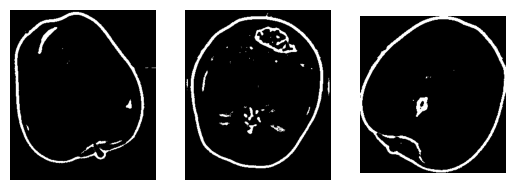

In [5]:
im_th = []
filled = []
for i in range(N):
    im_th.append(cv.bilateralFilter(nir_img[i],d=7,sigmaColor=45,sigmaSpace=45))
    im_th[i] = cv.adaptiveThreshold(im_th[i],255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY_INV,15,3)

plot_images(im_th)

I obtain binary images containing the edges of the apples, the defects, and others details of which I don't care. Therefore I isolate the contours of the apples selecting the connected components having the largest bounding box. Indeed in each image, excluding the background (the label having the index equal to 0), the component having the largest bounding box has to be the apple because I assume that no bigger components can be detected. In practice, I am assuming that every image contains an apple that covers almost all the area. This assumption is respected for each of the three images, and even if we had more images they likely will contain a single 'big' apple. 

To extract pieces of information about connected components in the binary images, I use **cv.connectedComponentsWithStats** function which computes the connected components labeled image of a binary image and also produces a statistics output for each label.

I could have also used the statistic "area" given by the OpenCV function (*connectedComponentsWithStats*), which retrieves the total number of pixels belonging to a connected component. I prefer to use the area of the bounding box because considering the number of pixels, there may have been some connected components with largest number of pixels than the apple. For example if there was a large defect and from the binarization resulted the connected component filled (not only the edge of the defect), this one could have been detected wrongly as the largest connected component in the image.

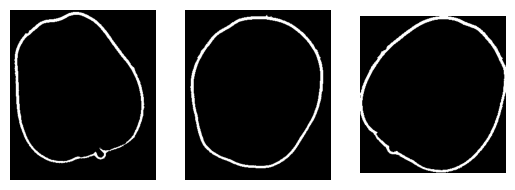

In [6]:
binary_mask = []
for i in range(N):
    
    # numLabels = number of connected components
    # labels = labeled image
    # stats = statistics output for each label
    (numLabels, labels, stats, _) = cv.connectedComponentsWithStats(im_th[i], 4)
    max_area = -np.inf
    j_mask = -1
    
    # iterate over labels, excluding labels[0] which is the background
    for j in range(1,numLabels):

        # w = horizontal size of the bounding box
        # h = vertical size of the bounding box 
        w = stats[j, cv.CC_STAT_WIDTH]
        h = stats[j, cv.CC_STAT_HEIGHT]
        area_bbox = h*w
        if area_bbox>max_area:
            max_area = area_bbox
            j_mask = j
    binary_mask.append((labels == j_mask).astype("uint8") * 255)

plot_images(binary_mask)

**FILLING THE SPACE INSIDE THE FRUIT BLOB USING A FLOOD FILL APPROACH**

Now I have binary masks that outline only the borders of the apples. I use a flood fill approach to fill the space inside the borders and obtain a binary mask of the fruits.

The **cv.floodFill** function fills a connected component starting from the seed point with the specified color.  
This function requires an operation mask that should be a single-channel 8-bit image, 2 pixels wider and 2 pixels taller than the image. 

I **flood-fill** the background using as seed the pixel (0,0). Before flood-filling, I pad the binary masks by one pixel on each dimension with intensities equal to 0 (black: the one associated with the background). In so doing I'm sure that even if the fruits touch or go over the borders of the images, the flood-filling still works correctly.
After the flood-filling, I remove the padding to maintain the shape of the binary masks coherent with that of the images. 
Then I invert the *holes* to get them as foreground (white pixels) and then I combine togheter, using the **OR** operator, the inverted *holes* and the *binary mask*, obtaining the binary mask with no holes anymore.

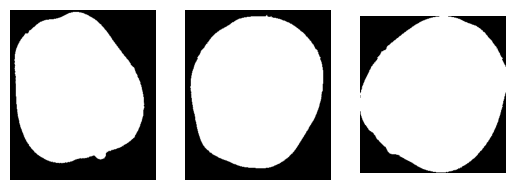

In [7]:
op_mask = []
for i in range(N):
    # padding the binary mask
    binary_mask[i] = np.pad(binary_mask[i], 1)
    
    h, w = binary_mask[i].shape[:2]
    op_mask.append(np.zeros((h+2, w+2), np.uint8))
    holes = binary_mask[i].copy()
    
    # flood fill background
    cv.floodFill(holes,op_mask[i] , (0, 0), 255)

    # remove padding
    holes = holes[1:-1,1:-1]
    binary_mask[i]=binary_mask[i][1:-1,1:-1]

    # get the holes as foreground (white)
    holes = cv.bitwise_not(holes)

    # OR operator between the binary mask and the inverted holes to fill the holes inside the binary mask
    binary_mask[i] = cv.bitwise_or(binary_mask[i],holes)
plot_images(binary_mask)


I find the contours of the apples from the binary masks, and draw them into the colors images.

I use the **cv.findContours** function that retrieves contours from a binary image:
- *binary_mask* : the binary image I want to process
- *cv.RETR_TREE* : (mode of the contour retrieval algorithm) retrieves all of the contours and reconstructs a full hierarchy of nested contours.
- *cv.CHAIN_APPROX_SIMPLE*: (the contour approximation algorithm) It removes all redundant points and compresses the contour. Instead *cv.CHAIN_APPROX_NONE* stores all the contour points using more memory. I try both retrieval algorithms and I can't see particular differences using one or another, so I decide to use the one that saves more memory.

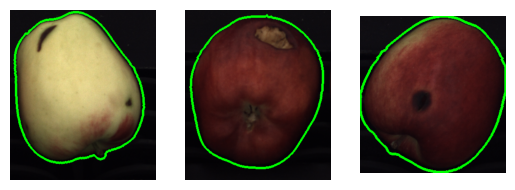

In [8]:
contours = []
output = []

for i in range(N):
    output.append(rgb_img[i].copy())
    cont, _ =  cv.findContours(binary_mask[i], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours.append(cont)
    cv.drawContours(output[i], contours[i], -1, (0,255,0), 3)

plot_images(output,color=True,rgb=False)



## Defects search

Now I want to detect the defects for each apple. As suggested in the assignment I use **Canny** edge detector to find the defects' edges. 
I work on the images obtained by applying the binary masks of the fruits on NIR images. Thus I'm working only on the apples, excluding a priori the background that doesn't contains informations I care about.

I apply the masks to the NIR images.

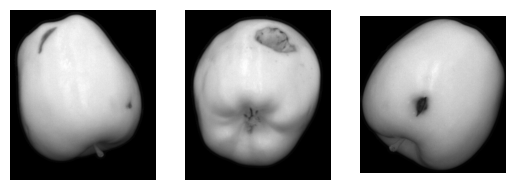

In [9]:
nir_fruit = []
for i in range(N):
    nir_fruit.append(cv.bitwise_and(nir_img[i],nir_img[i],mask=binary_mask[i]))
plot_images(nir_fruit,color=True,rgb=False)

Before applying Canny I denoise the NIR images. Indeed, without filtering the image , I notice that a lot of spurious edges, not correlated with fruit contours or defects' contours, are detected by Canny.

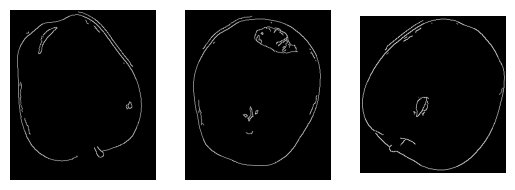

In [10]:
edges = []
for i in range(N): 
    edges.append(cv.Canny(nir_fruit[i],60,120))

plot_images(edges)

If I apply a bilateral filter before Canny, only fruit external edges and defects' edges appear. I use a **Bilateral Filter** to denoise the image without blurring the edges (edge preserve smoothing). The values of *d* (Diameter of each pixel neighborhood that is used during filtering ) and *sigmaColor* and *sigmaSpace* (filter sigma in color and coordinate space) were chosen after some empirical attempts.

The **cv.Canny** function computes the edges given an input image and the values of the two thresholds for hysteresis procedure. Also this parameters were tuned after some empirical attempts.

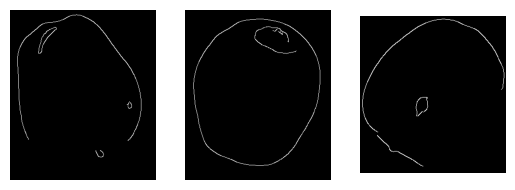

In [11]:
blurred_nir_fruit = []
for i in range(N):
    blurred_nir_fruit.append(cv.bilateralFilter(nir_fruit[i],d=9,sigmaColor=50,sigmaSpace=50))
    
    edges[i] = cv.Canny(blurred_nir_fruit[i],60,120)

plot_images(edges)

Now, I want to maintain only the defects' edges. I use the **Dilation** morphology operator to dilate the background. Then, I subtract it from the edges detected by Canny to remove the external edges of the fruits.

In OpenCV, you can create structuring elements using **cv.getStructuringElement** function,  passing it the shape and the dimension of the structuring element you want to use. In this case, I choose an elliptic structuring element because the defects have a circular shape.

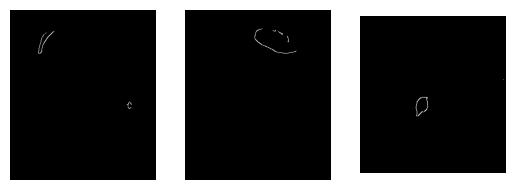

In [13]:
background = []
background_dilated = []
edges_intern = []
for i in range(N):

    # extract the background
    background.append(255 - binary_mask[i])

    # dilate the background
    background_dilated.append(cv.dilate(background[i],cv.getStructuringElement(cv.MORPH_ELLIPSE,(11,11)),iterations = 5))
    edges_intern.append(cv.subtract(edges[i],background_dilated[i]))

plot_images(edges_intern)

To obtain a binary mask of the defects I use the **Closing** morphological operator to "close" the foreground objects (defects). Again, I use a structuring element with an elliptical shape for the reasons explained above.

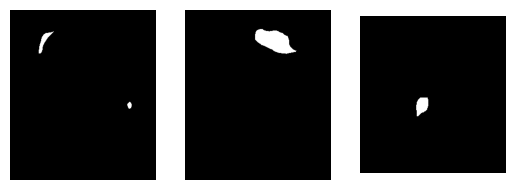

In [15]:
structuringElement = cv.getStructuringElement(cv.MORPH_ELLIPSE, (40, 40))
defects_binary_mask = []
for i in range(N):
    defects_binary_mask.append(cv.morphologyEx(edges_intern[i], cv.MORPH_CLOSE, structuringElement))

plot_images(defects_binary_mask)

Now I have binary images in which the connected components are the defects. So, to detect how many defects are there in the images and to highlight them, I use the **cv.connectedComponentsWithStats** function. I draw a red circle around each of the defects to outline them.

Total defects detected in image0 : 2
Total defects detected in image1 : 1
Total defects detected in image2 : 1


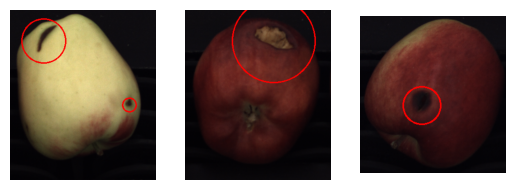

In [17]:
output = []
for i in range(N):
    (numLabels,labels, stats, centroids) = cv.connectedComponentsWithStats(defects_binary_mask[i], 4)

    # Subtracting by one because the first connected component is the background
    print("Total defects detected in image{} : {}".format(i,numLabels-1))

    # Create a copy of the original rgb image to draw on it the circles around defects
    output.append(cv.cvtColor(rgb_img[i].copy(),cv.COLOR_BGR2RGB))

    # Iterate over the samples
    for j in range(1,numLabels):
        w = stats[j, cv.CC_STAT_WIDTH]
        h = stats[j, cv.CC_STAT_HEIGHT]
        (cX, cY) = centroids[j]
        cv.circle(output[i], (int(cX), int(cY)), int(max(h,w)), (255, 0, 0), 2)

plot_images(output)

    

The defects are successfully detected for each of the three images, without false negatives or false positives. For the segmentation of the apples I could have used, as said before, more efficent solutions but I prefer to focus on the quality of segmentation rather than on speed of execution. 

# SECOND TASK

Images in folder “second task” show two apples with an unwanted reddish-brown area. I should identify the russet or at least some part of it with no false positive areas (if possible), in order to correctly classify the two fruits.

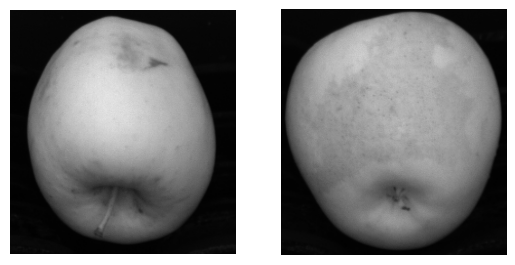

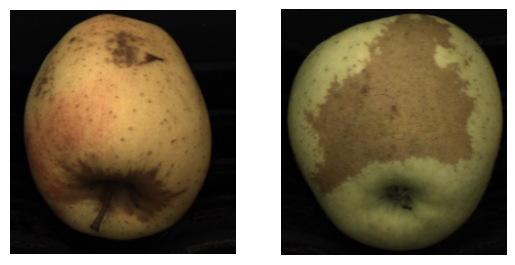

In [328]:
nir_img_filenames, rgb_img_filenames = get_img_filenames("second_task")
samples_filenames = get_samples_filenames()
N = len(nir_img_filenames)

nir_img = []
rgb_img = []
samples = []
for i in range(N):
    nir_img.append(cv.imread(nir_img_filenames[i],0))
    rgb_img.append(cv.cvtColor(cv.imread(rgb_img_filenames[i]),cv.COLOR_BGR2RGB))
for i in range(len(samples_filenames)):
    samples.append(cv.cvtColor(cv.imread(samples_filenames[i]),cv.COLOR_BGR2RGB))

plot_images(nir_img,color=False)
plot_images(rgb_img)

I follow those steps:
1. I create binary masks of the apples to focus the next steps only on the pixels belonging to the apples.
2. I compute a reference color from a set of samples that I assume were given to me to estimate the color of the russet area.
3. I compute a suitable Mahalanobis distance between the reference color and each pixel of the apples. For this purpose, I convert the images in the LUV colorspace. 
4. I create a binary mask of the russets using colour-based segmentation based on the Mahalanobis distance previously computed.

## Binary mask of the fruit

First, I create a binary mask of the apple. I follow the same steps of TASK1.

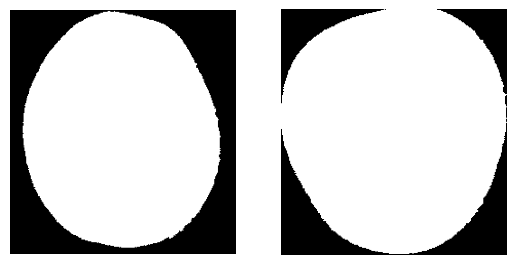

In [329]:
im_th = []
filled = []
binary_mask = []
op_mask = []
for i in range(N):
    # bilateral filter
    im_th.append(cv.bilateralFilter(nir_img[i],7,45,45))

    #adaptive threshold
    im_th[i] = cv.adaptiveThreshold(nir_img[i],255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,15,3)

    # invert the image
    im_th[i] = cv.bitwise_not(im_th[i])

    # connected components labeling
    (numLabels, labels, stats, _) = cv.connectedComponentsWithStats(im_th[i], 4)
    max_area = -np.inf
    j_mask = -1
    for j in range(1,numLabels):
        w = stats[j, cv.CC_STAT_WIDTH]
        h = stats[j, cv.CC_STAT_HEIGHT]
        area_bbox = h*w
        if (area_bbox>max_area):
            max_area = area_bbox
            j_mask = j
    binary_mask.append((labels == j_mask).astype("uint8") * 255)
    
    # padding the binary mask
    binary_mask[i] = np.pad(binary_mask[i], 1)
    
    h, w = binary_mask[i].shape[:2]
    op_mask.append(np.zeros((h+2, w+2), np.uint8))
    holes = binary_mask[i].copy()
    
    # flood fill background
    cv.floodFill(holes,op_mask[i] , (0, 0), 255)

    # remove padding
    holes = holes[1:-1,1:-1]
    binary_mask[i]=binary_mask[i][1:-1,1:-1]

    # get the holes as foreground (white)
    holes = cv.bitwise_not(holes)

    # OR operator between the binary mask and the inverted holes to fill the holes inside the binary mask
    binary_mask[i] = cv.bitwise_or(binary_mask[i],holes)

plot_images(binary_mask)

## Colour-based segmentation to detect russets

To detect russets, I calculate the Mahalanobis distance from each apple's pixel to a reference color which I estimate using a set of samples. I suppose to have some samples of the russets to estimate a reference color.

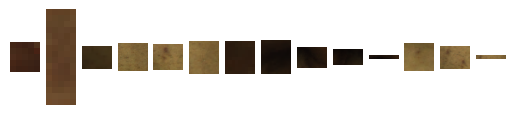

In [330]:
plot_images(samples)

I choose to use **LUV** which is a **perceptually uniform** colorspace. This means that a change in any direction of the color space is perceived by a human as the same change.  Instead, color differences in RGB space, do not correspond well to perceived differences in color. That is, two colors can be close in RGB space but appear very different to humans and vice versa.

Moreover,  LUV decouples the "color" (chromaticity, the UV part) and "lightness" (luminance, the L part) of color. So I compute the reference color just based on the UV part, which gives invariance to changes in different lighting conditions.

First, I convert the samples and the images into the LUV colorspace.

In [331]:
luv_samples = []
for i in range(len(samples)):
    luv_samples.append(cv.cvtColor(samples[i],cv.COLOR_RGB2LUV))
luv_img = []
for i in range(len(rgb_img)):
    luv_img.append(cv.cvtColor(rgb_img[i],cv.COLOR_RGB2LUV))

### Estimating the reference colour

I estimate the reference color (corresponding to the russets) taking the mean over the samples. Moreover, I need to estimate also the covariance matrix to compute the Mahalanobis distance.
The **cv.calcCovarMatrix** OpencCV function compute both, in particular:
- It takes as input the *samples* matrix which contains all the samples we want to consider
- Specifying the *COVAR_ROWS* flag, the function consider as single sample each row of the *samples* matrix
- *COVAR_NORMAL* : specify how the covariance matrix will be calculated
- *COVAR_SCALE* : if the flag is specified, the covariance matrix is scaled. In the "normal" mode, scale is 1./nsamples. This is just to obtain bigger numbers for the Mahalanobis distance in order to establish easier a threshold.

The samples have all different shapes, so I have to make some manipulation to the matrixes to obtain the 'overall' sample matrix containing all the samples as rows:
1. I compute the minimum width of all samples (*wmin*). This value will be the width of the overall *sample_matrix*.
2. Then for each of the samples, I extract all the sub-samples having width = wmin and I concatenate them in the *sample_matrix*

Then I reshape the sample matrix into a Nx2 matrix ( N = width X height ), considering only the UV part, and I pass it to the *calcCovarMatrix* OpencCv function.


In [332]:
# minimum width
w_min = np.Inf

# iterate over samples to get wmin
for i in range(len(luv_samples)):
    w = luv_samples[i].shape[1]
    if w < w_min:
        w_min=w

# initialize the first row of the sample matrix
sample_matrix = np.zeros((1,w_min,3),dtype=np.uint8)

# Iterate again over samples to concatenate sub-samples in the sample_matrix 
for i in range(len(luv_samples)):

    # get the width
    w = luv_samples[i].shape[1]

    # compute floor division
    n_subsamples = w // w_min
    for j in range(0,n_subsamples,w_min):

        # concatenate sub-samples
        sample_matrix = np.concatenate((sample_matrix,luv_samples[i][:,j:j+w_min,:]),axis=0)

# delete the first row which is only used for initialization and doesn't represent a sample
sample_matrix = sample_matrix[1:,:,:]

# consider only UV part and reshape into a Nx2 matrix
sample_reshaped = sample_matrix[:,:,1:3].reshape(sample_matrix.shape[0]*sample_matrix.shape[1],2)

# calculate covariance matrix and mean vector
covar, reference_color = cv.calcCovarMatrix(sample_reshaped,None,flags=cv.COVAR_ROWS | cv.COVAR_NORMAL | cv.COVAR_SCALE)

Now I have the covariance matrix estimated from the set of samples and the reference color computed as the mean over the samples.
To compute the Mahalanobis distance I need the **inverse of the covariance matrix**, which I can compute using the *Singular Value Decomposition* method, as suggested in OpenCV documentation. Then I compute a pixel-wise Mahalanobis distance (considering only pixels belonging to the binary mask of the apple to be more efficient) using the **cv.Mahalanobis** function which takes as inputs two 1D arrays and the inverse covariance matrix (computed preferably using the SVD method). A pixel belongs to a russet if its Mahalanobis distance from the reference color is less than a threshold, selected after some empirical attempts. 

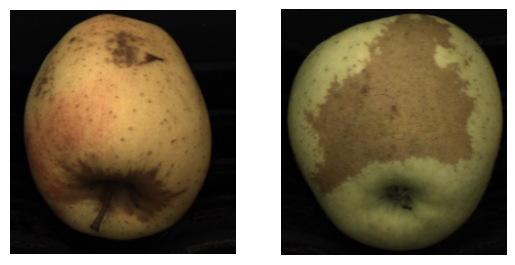

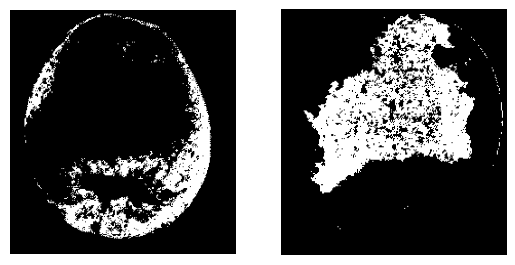

In [333]:
# invert the covariance matrix
inv_cov = cv.invert(covar, cv.DECOMP_SVD)

russets = []
for x in range(len(luv_img)):
    russet = np.zeros((luv_img[x].shape[0],luv_img[x].shape[1]),dtype = np.uint8)
    for i in range(luv_img[x].shape[0]):
        for j in range(luv_img[x].shape[1]):

            # consider only pixels belonging to the binary mask
            if binary_mask[x][i][j]==255:

                # compute the Mahalanobis distance
                mahal_dst = cv.Mahalanobis(np.float64(reference_color.flatten()),np.float64(luv_img[x][i,j,1:3]),inv_cov[1])

                # if the distance is less than a threshold, the pixel belongs to a russet
                if mahal_dst<1.27:
                    russet[i,j]=255
    russets.append(russet)

plot_images(rgb_img,color=True,rgb=True)
plot_images(russets,color=False)


I obtain a binary mask of the russets, which isn't super accurate. To refine the mask I apply some morphological operations. 

At first, I dilate the background (as I did in TASK1) and I subtract it from the original binary mask of the russets, to delete pixels wrongly detected as russets that belong to the contours of the apple. This probably happens because the light isn't uniform in the scene and so along borders pixels are darker and their Mahalanobis distance results smaller than it was under uniform light condition.

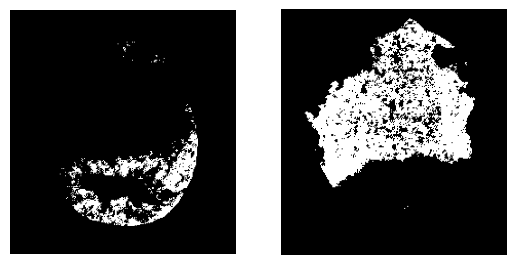

In [327]:
background = []
background_dilated = []
russet_without_borders = []
for i in range(len(luv_img)):
    
    # get the background
    background.append(255 - binary_mask[i])

    # dilate the background
    background_dilated.append(cv.dilate(background[i],cv.getStructuringElement(cv.MORPH_ELLIPSE,(13,13)),iterations = 4))
    
    # subtract the bg from the original binary mask of the russets
    russet_without_borders.append(cv.subtract(russets[i],background_dilated[i]))

plot_images(russet_without_borders)

Then I close the background in order to obtain a "filled" binary mask of the russets.

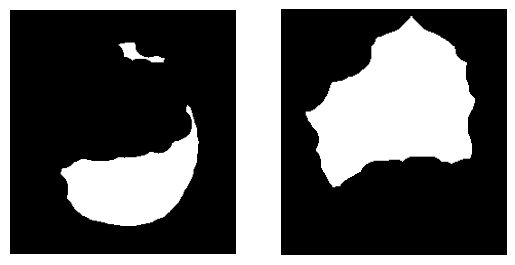

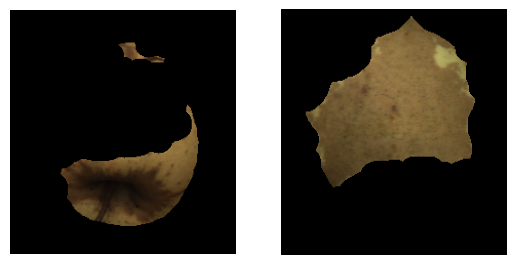

In [334]:
final_russet = []
russets_rgb = []

structuringElement = cv.getStructuringElement(cv.MORPH_ELLIPSE, (30, 30))
for i in range(len(luv_img)):
    # close the background
    final_russet.append(cv.morphologyEx(russet_without_borders[i], cv.MORPH_CLOSE, structuringElement))

    # apply the binary mask to RGB image
    russets_rgb.append(cv.bitwise_and(rgb_img[i],rgb_img[i],mask=final_russet[i]))

plot_images(final_russet)
plot_images(russets_rgb,color=True,rgb=True)

I apply connected components labeling in order to outline the defects in the RGB image.

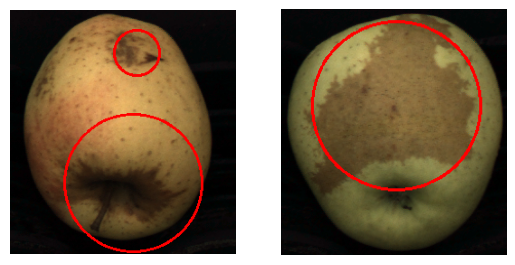

In [335]:
output = []
for i in range(len(luv_img)):
    (numLabels,labels, stats, centroids) = cv.connectedComponentsWithStats(final_russet[i], 4)
    output.append(cv.cvtColor(luv_img[i].copy(),cv.COLOR_LUV2RGB))
    for j in range(1,numLabels):
        w = stats[j, cv.CC_STAT_WIDTH]
        h = stats[j, cv.CC_STAT_HEIGHT]
        (cX, cY) = centroids[j]
        area = stats[j, cv.CC_STAT_AREA]
        
        # draw a red circle around each russet
        cv.circle(output[i], (int(cX), int(cY)), int(w/2), (255, 0, 0), 2)

plot_images(output,color=True,rgb=True)


The main russets are detected pretty well with no false positives, as indicated in the assignment. 

To find a suitable Mahalanobis distance I found a lot of problems, mainly related to the fact that the two apples have two slightly different colors (the first one tends to yellow, the second one to green) and also the russets are slightly different (being darker in the first image). Thus sometimes the 'non-russet' parts of the first apple are very similar to the russet of the second one. 
Moreover, the russet in the second image is bigger and easier to detect than the russets in the first one, and as you can see it's detected more precisely.

The success of this solution is also connected with the quality of the samples to estimate the reference color. Significative samples which represent well the russets are important to estimate a good reference color. Here I have only two images and I have to extract the samples from them, maybe in a real scenario I can estimate the reference color from a larger set of samples.

# THIRD TASK

Images in folder “final challenge” show 5 kiwis. I should segment the fruits and locate the defect in image “000007”. Special care should be taken to remove as “background” the dirt on the conveyor as well as the sticker in image “000006”.

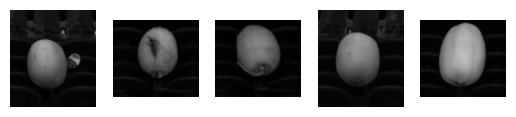

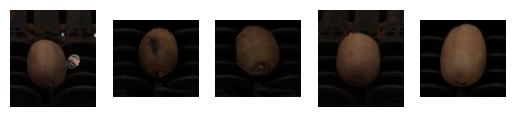

In [10]:
nir_img_filenames, rgb_img_filenames = get_img_filenames("final_challenge")
N = len(nir_img_filenames)

nir_img = []
rgb_img = []
for i in range(N):
    nir_img.append(cv.imread(nir_img_filenames[i],0))
    rgb_img.append(cv.cvtColor(cv.imread(rgb_img_filenames[i]),cv.COLOR_BGR2RGB))

plot_images(nir_img)
plot_images(rgb_img,color=True,rgb=True)

Similarly to what I did in the first task, I follow 2 main steps:
1. I create a binary mask of the kiwis, trying to isolate them from the conveyor belt on the background and the stickers.
1. Detect wheter the defects are present or not on kiwis.

## Create a BINARY MASK of kiwis

First I tried the same approach, used in the first task, using adaptive thresholding. I didn't obtain good results. Indeed, I found out difficult to establish the right combination of parameters to get a binary mask of the contours of the fruits. In particular, as you can see in the image below, I get broken contours, which don't permit to create a binary mask of the kiwis using a flood-fill approach.

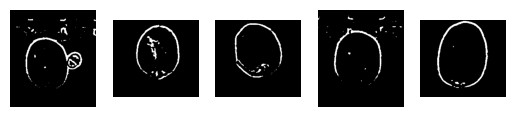

In [11]:
im_th = []
filled = []
for i in range(N):
    im_th.append(cv.bilateralFilter(nir_img[i],d=7,sigmaColor=45,sigmaSpace=45))
    im_th[i] = cv.adaptiveThreshold(im_th[i],255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY_INV,13,4)

plot_images(im_th)

This probably happens because some parts of the images are too dark and the contrast between the kiwis and the conveyor belt isn't enough to permit to distinguish the pixels belonging to the kiwis and pixels belonging to the conveyor belt. It didn't happen when analyzing apples because the color of the apples is sharply different from the color of the conveyor belt, and so the NIR images have a high contrast between the apples and the conveyor belt. Kiwis have a darker color, and so when the light isn't enough, it's difficult to distinguish the fruit from the conveyor belt.

Those considerations drive me to enhance the contrast of the images before applying thresholding.

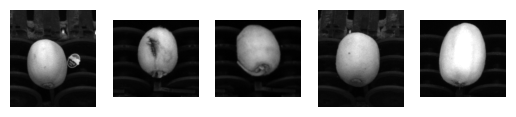

In [12]:
higher_contrast = []
for i in range(N):
    
    # Enanche contrast by multiplicating each pixel by a fixed value
    higher_contrast.append(nir_img[i]*1.5)
plot_images(higher_contrast)

Then I apply global thresholding with Otsu's method on the higher-contrast images. All parts of the kiwis appear as foreground and so I'm satisfied with this segmentation. However, togheter with kiwis, some parts of the conveyor belt and a sticker in the image “000007” are considered as background.  Therefore I have to process the binary images obtained, to remove the parts belonging to the conveyor and the sticker.  

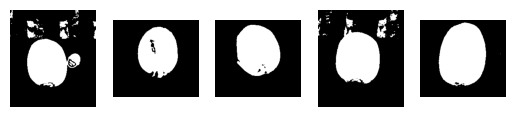

In [13]:
im_th = []
equal = []
for i in range(N):
    thresh, im_thresh = cv.threshold(higher_contrast[i],50,255,cv.THRESH_BINARY)
    im_th.append(im_thresh)
plot_images(im_th)    


### Removing dirt of the conveyor and sticker

I can remove parts of the conveyor labeling the connected components and maintaining the one with the largest bounding box, which has to be the one representing the kiwi, supposing as done in TASK1 that every image contains a single 'big' kiwi.

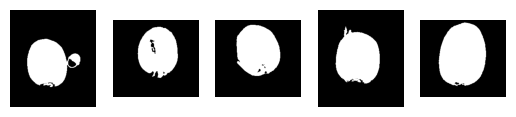

In [14]:
binary_mask = []
for i in range(N):
    (numLabels, labels, stats, _) = cv.connectedComponentsWithStats(np.uint8(im_th[i]), 4)
    max_area = -np.inf
    j_mask = -1
    for j in range(1,numLabels):
        w = stats[j, cv.CC_STAT_WIDTH]
        h = stats[j, cv.CC_STAT_HEIGHT]
        area_bbox = h*w
        if (area_bbox>max_area):
            max_area = area_bbox
            j_mask = j
    binary_mask.append((labels == j_mask).astype("uint8") * 255)
plot_images(binary_mask)

I obtain a binary mask with no parts of the conveyor, but the sticker in image "000007" still appears. 
I separate the sticker from the kiwi by applying the **ERODE** morphological operation. I use a structuring element with an elliptical shape and a size of 3x3.

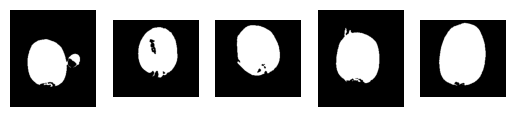

In [15]:
for i in range(N):
    binary_mask[i]=cv.erode(binary_mask[i],cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)),iterations=1)

plot_images(binary_mask)

I apply again the connected components labeling and I consider only the connected component having the largest bounding box. So doing I throw away the blob corresponding to the sticker. Now I have the binary masks of the kiwis.

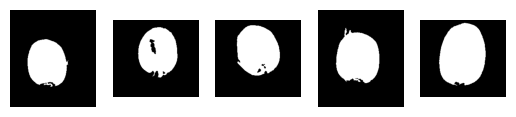

In [16]:
for i in range(N):
    (numLabels, labels, stats, _) = cv.connectedComponentsWithStats(binary_mask[i], 4)
    max_area = -np.inf
    j_mask = -1
    for j in range(1,numLabels):
        w = stats[j, cv.CC_STAT_WIDTH]
        h = stats[j, cv.CC_STAT_HEIGHT]
        area_bbox = h*w
        if (area_bbox>max_area):
            max_area = area_bbox
            j_mask = j
    binary_mask[i] = (labels == j_mask).astype("uint8") * 255
plot_images(binary_mask)

The binary masks have some holes and I want to fill them. The procedure is the same as in TASK1:
- pad the binary mask to guarantee that flood-filling works even if the fruits borders go outside the images 
- flood fill using as seed (0,0)
- remove padding
- invert the binary image representing the holes
- apply OR operator between the binary mask and the inverted holes

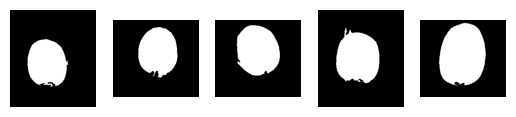

In [17]:
op_mask = []
for i in range(N):
    # padding the binary mask
    binary_mask[i] = np.pad(binary_mask[i], 1)
    
    h, w = binary_mask[i].shape[:2]
    op_mask.append(np.zeros((h+2, w+2), np.uint8))
    holes = binary_mask[i].copy()
    
    # flood fill background
    cv.floodFill(holes,op_mask[i] , (0, 0), 255)

    # remove padding
    holes = holes[1:-1,1:-1]
    binary_mask[i]=binary_mask[i][1:-1,1:-1]

    # get the holes as foreground (white)
    holes = cv.bitwise_not(holes)

    # OR operator between the binary mask and the inverted holes to fill the holes inside the binary mask
    binary_mask[i] = cv.bitwise_or(binary_mask[i],holes)
plot_images(binary_mask)


I apply another **ERODE** morpholgical operation to refine the borders of the kiwis.

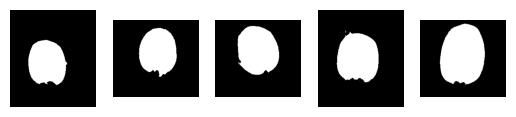

In [18]:
for i in range(N):
    binary_mask[i]=cv.erode(binary_mask[i],cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)),iterations=2)

plot_images(binary_mask)

Then I draw the contours of the kiwis to highlight them.

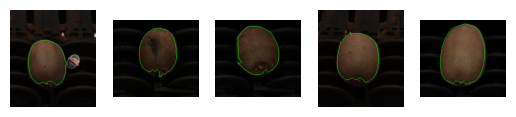

In [19]:
contours = []
output = []

for i in range(N):
    cont, _ =  cv.findContours(binary_mask[i], cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
    contours.append(cont)
    output.append(rgb_img[i].copy())
    cv.drawContours(output[i], contours[i], -1, (0,255,0), 1)

plot_images(output,color=True,rgb=True)

The kiwis are succesfully segmented, removing the dirt on the conveyor and the sticker on image "000006".

## Detect defects

Now I want to detect whether the kiwis have some imperfections on their surface. I use Canny's edge detector to find the defects and the procedure is identical to the one in the first task. So I will not go deep into details because you can find the same considerations in the TASK1.

I apply the binary mask to the NIR images.

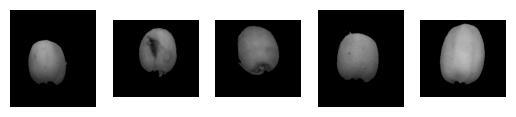

In [20]:
nir_fruit = []
for i in range(N):
    cv.bitwise_and(nir_img[i],nir_img[i],mask=binary_mask[i])
    nir_fruit.append(cv.bitwise_and(nir_img[i],nir_img[i],mask=binary_mask[i]))
plot_images(nir_fruit,color=True,rgb=False)

I denoise the images using a **Bilateral Filter** to smooth without blurring the edges and then I apply **Canny**.

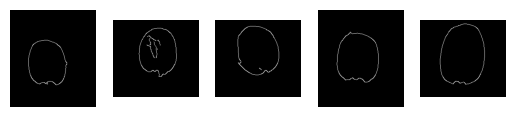

In [21]:
edges = []
blurred_nir_fruit = []
for i in range(N):
    blurred_nir_fruit.append(cv.bilateralFilter(nir_fruit[i],d=10,sigmaSpace=45,sigmaColor=45))
    edges.append(cv.Canny(blurred_nir_fruit[i],35,70))

plot_images(edges)

I use the **Dilation** morphology operator to dilate the background. Then, I subtract it from the edges detected by Canny to remove the external edges of the fruits and maintain only the ones of the defects.

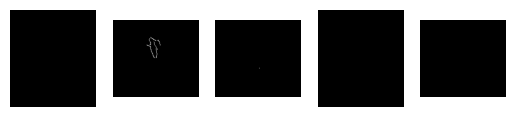

In [22]:
background = []
background_dilated = []
edges_intern = []
for i in range(N):
    # get the bg
    background.append(255 - binary_mask[i])

    # dilate bg
    background_dilated.append(cv.dilate(background[i],cv.getStructuringElement(cv.MORPH_ELLIPSE,(15,15)),iterations = 2))
    
    # subtract the dilated bg from the edges detected by Canny
    edges_intern.append(cv.subtract(edges[i],background_dilated[i]))

plot_images(edges_intern)

To obtain a binary mask of the defects I use the **Closing** morphological operator to "close" the foreground objects (defects).

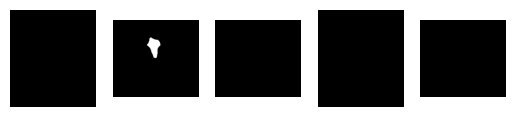

In [23]:
structuringElement = cv.getStructuringElement(cv.MORPH_ELLIPSE, (40, 40))
defects_binary_mask = []
for i in range(N):
    defects_binary_mask.append(cv.morphologyEx(edges_intern[i], cv.MORPH_CLOSE, structuringElement))

plot_images(defects_binary_mask)

I apply connected components labeling to detect which kiwis contain defects. If some defects were found, I highlight them with a red circle.

Total defects detected in image0 : 0
Total defects detected in image1 : 1
Total defects detected in image2 : 0
Total defects detected in image3 : 0
Total defects detected in image4 : 0


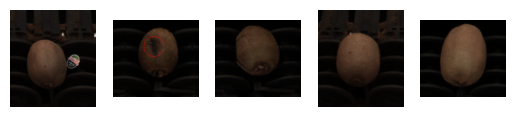

In [24]:
output = []
for i in range(N):
    (numLabels, labels, stats, centroids) = cv.connectedComponentsWithStats(defects_binary_mask[i], 4)
    print("Total defects detected in image{} : {}".format(i,numLabels-1))
    output.append(rgb_img[i].copy())
    for j in range(1,numLabels):
        x = stats[j, cv.CC_STAT_LEFT]
        y = stats[j, cv.CC_STAT_TOP]
        w = stats[j, cv.CC_STAT_WIDTH]
        h = stats[j, cv.CC_STAT_HEIGHT]
        (cX, cY) = centroids[j]
        cv.circle(output[i], (int(cX), int(cY)), int(h/2), (255, 0, 0), 1)
plot_images(output)

# CONCLUSIONS

In this project I focus more on the quality of the results (accurate segmentation and localization of defects) rather than on performance. 
The software system, tested on the few given images, has obtained good results in all the tasks.Maybe if it was tested on more images, they could arise problems that have not been considered in this project and the quality could not be the same.
But for the scope of this project, all the goals have been successfully achieved.